# Project 1 Machine Learning
## Build predictive models to predict a classifiction, i.e., player's hand (righty or lefity) by using the ATP historic match data or if a palyer wins a match based on the historic match results.


### Used OLS and Lasso to exam the importance of the features and evaluate the relationship between the predictor variables and response variable

### Used the below models to learn the predictor variables and predict the response variable

   KNeighborsClassifier

   LogisticRegression

   Bagging - RandomForestClassifier

   Boosting - Gradient Boosting

### Used train_test_split, cross_val_score, GridSearchCV to tune and learn models

### Used learning_curve and other metric to compare the model performance


In [2064]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
import seaborn as sns; sns.set(color_codes=True)
from os import listdir
import re
from scipy.stats import stats
from scipy import stats
from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib as mpl
import statsmodels.formula.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Lasso, Ridge, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.dummy import DummyRegressor

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2065]:
df = pd.read_csv('data/RL_v.csv')
df2 = pd.read_csv('data/RL_h.csv')
df_all = pd.read_csv('data/all_v_00_19.csv')

Add a few calcualted columns

In [2066]:
df_all.loc[df_all.player_hand=='R', 'player_hand_flag'] = 1
df_all.loc[df_all.player_hand=='L', 'player_hand_flag'] = 0

In [2067]:
df_all['svpt_won_pct']= np.around((df_all.sv1stWon + df_all.sv2ndWon)/df_all.svpt,2)
df_all['svpt_std_var']=df_all.svpt - df_all.SvGms*4
df_all['bpSaved_pct'] = np.around(df_all.bpSaved/df_all.bpFaced,2)
df_all.bpSaved_pct.fillna(0, inplace=True)

In [2068]:
df.loc[df.player_hand=='R', 'player_hand_flag'] = 1
df.loc[df.player_hand=='L', 'player_hand_flag'] = 0

In [2069]:
df.loc[(df.surface=='Hard'), 'surface_id'] = 1
df.loc[(df.surface=='Clay'), 'surface_id'] = 2
df.loc[(df.surface=='Grass'), 'surface_id'] = 3
df.loc[(df.surface=='Carpet'), 'surface_id'] = 4

In [2070]:
df.loc[(df.tourney_level=='A'), 'tourney_level_id'] = 1
df.loc[(df.tourney_level=='G'), 'tourney_level_id'] = 2
df.loc[(df.tourney_level=='M'), 'tourney_level_id'] = 3

In [2071]:
df.loc[(df.player_rank >=1) & (df.player_rank<=30), 'player_rank_group'] = 1
df.loc[(df.player_rank >=11) & (df.player_rank<=60), 'player_rank_group'] = 2
df.loc[(df.player_rank >=61) & (df.player_rank<=100), 'player_rank_group'] = 3
df.loc[(df.player_rank >=101), 'player_rank_group'] = 4

add svpt_won_pct and bpSaved_pct to make serving data at the same scale

In [2072]:
df['svpt_won_pct']= np.around((df.sv1stWon + df.sv2ndWon)/df.svpt,2)

In [2073]:
# calculate how many additaionl serves to win the serving game.  
df['svpt_std_var']=df.svpt - df.SvGms*4

In [2074]:
df['bpSaved_pct'] = np.around(df.bpSaved/df.bpFaced,2)
df.bpSaved_pct.fillna(0, inplace=True)

In [2075]:
df.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'player_hand_flag',
       'surface_id', 'tourney_level_id', 'player_rank_group', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct'],
      dtype='object')

There are 14 rows have data issues on svpt_won_pct.  Since volume is small so just ignore it.

In [2076]:
df[df.svpt_won_pct>=1][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']].head()

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2460,6-2 3-6 6-4,32.0,0.70,47.0,46.0,1.78,-6.0,13.0,0.07,0.15,15.0,12.0,1,35.0,3.0,7.0,9.0,5.0,29.51,127.0
2461,6-2 3-6 6-3,27.0,0.52,38.0,52.0,1.38,0.0,13.0,0.12,0.08,15.0,11.0,1,34.0,6.0,4.0,3.0,1.0,22.06,35.0
2462,3-6 7-5 6-2,41.0,0.73,56.0,56.0,1.46,0.0,14.0,0.14,0.04,16.0,13.0,1,26.0,8.0,2.0,3.0,1.0,24.84,37.0
2463,7-6(2) 6-4,36.0,0.73,42.0,49.0,1.43,5.0,11.0,0.06,0.10,12.0,10.0,1,28.0,3.0,5.0,1.0,0.0,24.01,21.0
2464,6-4 3-6 6-3,39.0,0.70,47.0,56.0,1.41,0.0,14.0,0.30,0.14,15.0,13.0,1,32.0,17.0,8.0,3.0,2.0,22.06,35.0


In [2077]:
df[df.svpt_won_pct>=1].player_id.count()

14

In [2078]:
df[(df.tourney_id=='2003-1536') & (df.player_id==103819)][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']]

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2466,4-6 7-6(3) 6-4,42.0,0.63,52.0,67.0,1.46,3.0,16.0,0.15,0.06,16.0,16.0,1,46.0,10.0,4.0,8.0,7.0,22.18,3.0


Functions

In [2079]:
def plot_ol_coef(axis_names, f):
    # use Ordinary Least Squares to exam the relationship between the predictor variables (the X) and the response (the y)
    reg = sm.ols(f, data=df).fit()
    reg_results = reg.summary()
    print(reg_results)
    # print
    print('params:')
    print(reg.params)
    print()
    print()
    print('conf_int:')
    print(reg.conf_int())
    print()
    print()
    print('err_series:')
    err_series = reg.params - reg.conf_int()[0]
    print(err_series)
    print()
    print()
    print('coef_df:')
    coef_df = pd.DataFrame({'coef': reg.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
    print(coef_df)
    print()
    print()
    
    # plot
    fig, ax = plt.subplots(figsize=(12 ,5))
    # plot error bar
    coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, #color='none', 
             yerr='err', 
             legend=False)
    ax.set_ylabel('coef')
    ax.set_xlabel('columns')
    # scatter plot 
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(axis_columns, 
                       rotation=45, fontsize=16)
    
    return reg.params, reg.conf_int(), err_series, coef_df

In [2080]:
#sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [2081]:
def display_plot(cv_scores, cv_scores_std):
    alpha_space = np.logspace(-4, 0, 50)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [2082]:
#from sklearn.linear_model import Lasso
#from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
def plot_lasso_alpha(X,y):
    alpha_space = np.logspace(-4, 0, 50)
    lasso_scores = []
    lasso_scores_std = []
    
    # Create a ridge regressor: ridge
    lasso = Lasso(normalize=True)
    
    # Compute scores over range of alphas
    for alpha in alpha_space:
        # Specify the alpha value to use: ridge.alpha
        lasso.alpha = alpha
        
        # Perform 5-fold CV: lasso_cv_scores
        lasso_cv_scores = cross_val_score(lasso,X,y,cv=5)
        
        # Append the mean of ridge_cv_scores to ridge_scores
        lasso_scores.append(np.mean(lasso_cv_scores))
        
        # Append the std of ridge_cv_scores to ridge_scores_std
        lasso_scores_std.append(np.std(lasso_cv_scores))
        
    # Display the plot
    display_plot(lasso_scores, lasso_scores_std)
    return lasso_scores, lasso_scores_std
  

In [2083]:
def plot_lasso_features(names, X, y, alpha=0.01):
    
    plt.figure(figsize=(8,8))
    
    lasso = Lasso(alpha=alpha)
    lasso_coef = lasso.fit(X, y).coef_ 
    _ = plt.plot(range(len(names)), lasso_coef) 
    _ = plt.xticks(range(len(names)), names, rotation=60) 
    _ = plt.ylabel('Coefficients') 
    plt.show() 

In [2084]:
def make_CV_models(X, y):
    '''performs grid searches to find all the best models for dataset X, y'''

    model_dict = {
            #'KRR'    : GridSearchCV(X, y, KernelRidge(), param_grid={"alpha": np.logspace(-10, 2, 300), "gamma": np.logspace(-10, -1, 100), "kernel" : ['rbf']}),
          #  'SVR'   : GridSearchCV(X, y, SVR(), param_grid={"C": np.logspace(-1, 4, 20), "epsilon": np.logspace(-2, 2, 20)}),
           # 'Ridge' : GridSearchCV(X, y, Ridge(), param_grid={"alpha": np.logspace(-6, 6, 150)} ),
           # 'Lasso' : GridSearchCV(X, y, Lasso(max_iter = 20000), param_grid={"alpha": np.logspace(-2, 6, 100)} ),
          #  'BR'    : GridSearchCV(X, y, BayesianRidge(), param_grid={"alpha_1": np.logspace(-13,-5,10),"alpha_2": np.logspace(-9,-3,10), "lambda_1": np.logspace(-10,-5,10),"lambda_2": np.logspace(-11,-4,10)}) ,
          #  'GBoost': GridSearchCV(X, y, GradientBoostingRegressor(), param_grid={"n_estimators": np.linspace(5, 350, 100).astype('int')} ),
          #  'RF'    : GridSearchCV(X, y, RandomForestRegressor(), param_grid={"n_estimators": np.linspace(5, 100, 50).astype('int')}, ),
            'kNN'   : GridSearchCV(X, y, KNeighborsRegressor(), param_grid={"n_neighbors": list(range(1, 31))} )#,
          #  'mean'  : DummyRegressor(strategy='mean'),
            }

    return model_dict

In [2085]:
def knn_k_grid_search(X, y, n_CV=5):
    #from sklearn.grid_search import GridSearchCV 
    
    '''
    knn = KNeighborsClassifier()
     
    k_range = np.arange(1,31)
    
    params = {"n_neighbors": k_range,  
          "metric": ["euclidean", "cityblock"]} 
    grid = GridSearchCV(estimator=knn, param_grid=params, cv=n_CV, scoring='accuracy', n_jobs=-1) #scoring='roc_auc') 
    grid.fit(X, y) 
    print(grid.best_score_) 
    print(grid.best_estimator_.n_neighbors)
    '''
    k_range = list(range(1, 31))
    print(k_range)
    
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    knn = KNeighborsClassifier()
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=n_CV, scoring='roc_auc', n_jobs=-1) #scoring='roc_auc' scoring='accuracy'
    # fit the grid with data
    grid.fit(X, y)

    grid_mean_scores = grid.cv_results_['mean_test_score']
    print('')
    print('Mean Test Score')
    print(grid_mean_scores.mean())
    
    knn_neighbors = grid.best_params_
    print(knn_neighbors)
    print(grid.best_score_)
    
    # plot the results
    # this is identical to the one we generated above
    plt.plot(k_range, grid_mean_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    
    return grid, grid.best_estimator_.n_neighbors

In [2086]:
def knn_cross_val_scores(X, y, k, cv=5):
    # K-fold cross-validation

    knn = KNeighborsClassifier(n_neighbors=k)
    
    cv_scores = cross_val_score(knn, X, y, cv=n_CV, scoring='roc_auc', n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [2087]:
def get_cross_val_scores(model, X, y, cv=5):
    # K-fold cross-validation
    
    cv_scores = cross_val_score(model, X, y, cv=n_CV, scoring='roc_auc', n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [2088]:
def run_train_testing_split(model, X_train, X_test, y_train, y_test):
    # train and test split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)  
    
    #knn = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('classification report:')
    print(classification_report(y_test, y_pred))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('mean squared error:')
    print(mean_squared_error(y_test, y_pred))
    print('r2 scores:')
    print (r2_score(y_test, y_pred))
    
    # ROC Curve
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print('ROC AUC Score: ')
    print(auc_score)
    #print('ROC AUC Score: ' + str(auc_score))    
    print()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

    plt.figure(figsize=(12,12))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [2089]:
def knn_cross_val_k_search(X,y,cv=5):
    # parameter tuning using cross_val_score
    # Goal: To select the best value of k for KNN model to predict
    
    k_range = range(1, 31)
    
    # list of scores from k_range
    k_scores = []
    
    #loop through reasonable values of k
    for k in k_range: 
        # run KNeighborsClassifier with k neighbours
        knn = KNeighborsClassifier(n_neighbors=k)
        # obtain cross_val_score for KNeighborsClassifier with k neighbours
        scores = cross_val_score(knn, X, y, cv=cv, scoring='roc_auc') # scoring='accuracy'
        # append mean of scores for k neighbors to k_scores list
        k_scores.append(scores.mean())
    print(k_scores)
    
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    return k_range, k_scores

In [2100]:
def plot_learning_curve(model, X, y):
    # visualize the effect of the number of observations on the performance metric
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model,#KNeighborsClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        #scoring='roc_auc',
                                                        shuffle=True,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        #train_sizes=np.linspace(0.01, 1.0, 50)
                                                        train_sizes=np.linspace(0.01, 1.0, 30)
                                                           )
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.5)#"#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.5)#"#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [2091]:
n_CV = 10
p_test_size = 0.2
p_random_state= 42

# KNN

## Machine learning for Data Set 1 of selected predicotr variables (Xs) and response (won_flag) 

In [2092]:
model_columns=['sv1stIn', 'sv1stWon','svpt','sv2ndWon','ace','df','bpFaced', 'bpSaved', 'svpt_std_var']

names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

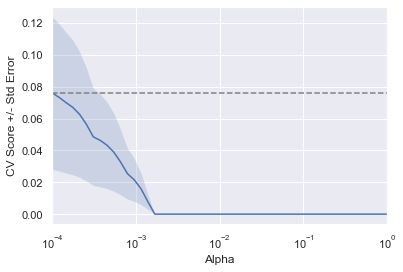

([0.07597072018929614,
  0.07324605797823291,
  0.07001225925692642,
  0.06697739016869615,
  0.06258544077563907,
  0.056264648887037416,
  0.04848116624859582,
  0.04632226625998748,
  0.04325584850798627,
  0.03888455359449021,
  0.03263290477963223,
  0.02539295374864674,
  0.02145100741875485,
  0.01580285802581729,
  0.007689051693476734,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -

In [2093]:
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

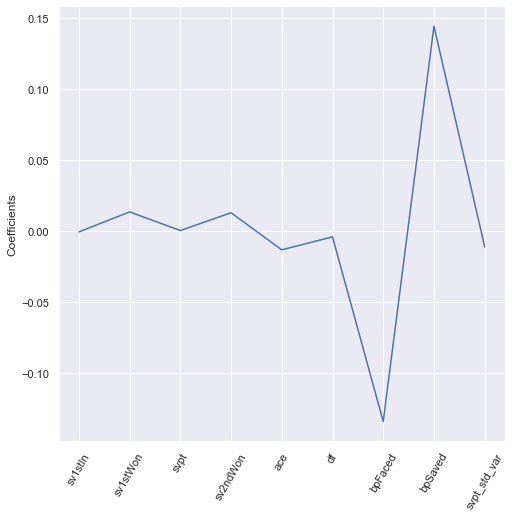

In [2094]:
plot_lasso_features(names, X, y, 0.001)

### Choose the best n_neighbors 

[0.7157483808405672, 0.7712733235929219, 0.8002885695291473, 0.8165533401181205, 0.8254155975036372, 0.8336683072887865, 0.8400847603039905, 0.845275216843274, 0.847678655180672, 0.8501037746353436, 0.8517456003722597, 0.8540747487072619, 0.8554064233545529, 0.856418904235057, 0.8565658685660613, 0.8576585837923352, 0.8580632190649963, 0.8581302934686137, 0.8588064587592024, 0.8595151821280425, 0.8599942311175495, 0.8604929479825112, 0.8614905011757319, 0.8617904009468023, 0.862512266594269, 0.8628079982370165, 0.8627519404877981, 0.8630125571487179, 0.8628862389021752, 0.863359561149843]


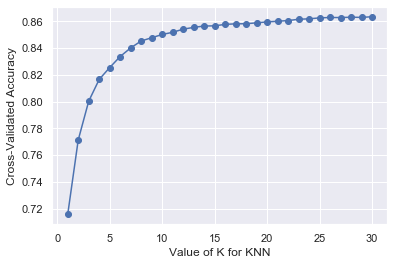

In [2095]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8444534688782358
{'n_neighbors': 30}
0.8633605000852458


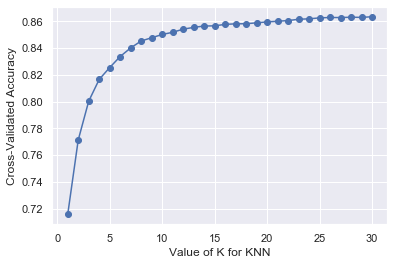

In [2096]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

classification report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1998
           1       0.77      0.77      0.77      2029

    accuracy                           0.77      4027
   macro avg       0.77      0.77      0.77      4027
weighted avg       0.77      0.77      0.77      4027

confusion matrix:
[[1543  455]
 [ 466 1563]]
mean squared error:
0.22870623292773776
r2 scores:
0.08512085274036973
ROC AUC Score: 
0.8649106227962808



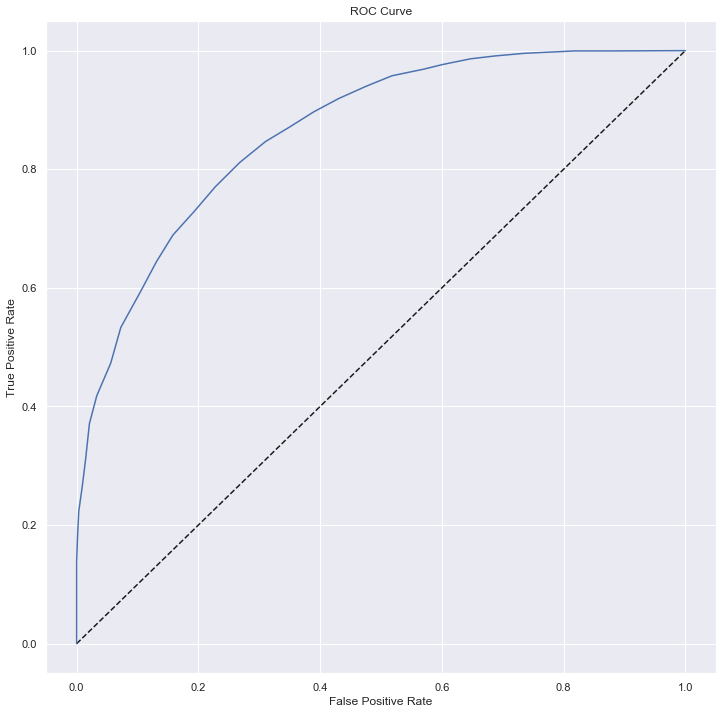

In [2097]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [2098]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.8170936  0.81454433 0.88229064 0.87631773 0.83652709 0.86125616
 0.84146552 0.84305419 0.79644528 0.85194537]
Average CV Score:
0.8420939912090326




array([0.8170936 , 0.81454433, 0.88229064, 0.87631773, 0.83652709,
       0.86125616, 0.84146552, 0.84305419, 0.79644528, 0.85194537])

### Exam learninig performance¶ 

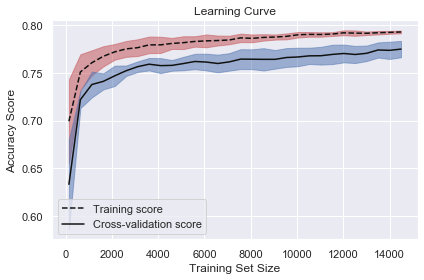

In [2102]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

When size increases, training score increases and variance decreases.
When size increases, testig score increase.  But the variance doesn't decrease.

## Machine learning for Data Set 2 of selected predicotr variables (Xs) and response (won_flag) 

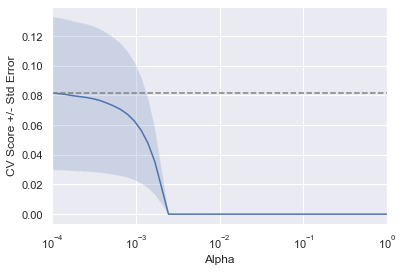

([0.08155531912299578,
  0.08114158418633104,
  0.0805742558977433,
  0.0797902700485535,
  0.07919137528478712,
  0.0785651069215781,
  0.07769774718282252,
  0.07648837861680773,
  0.07479209457655338,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.71153807

In [2103]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns= ['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

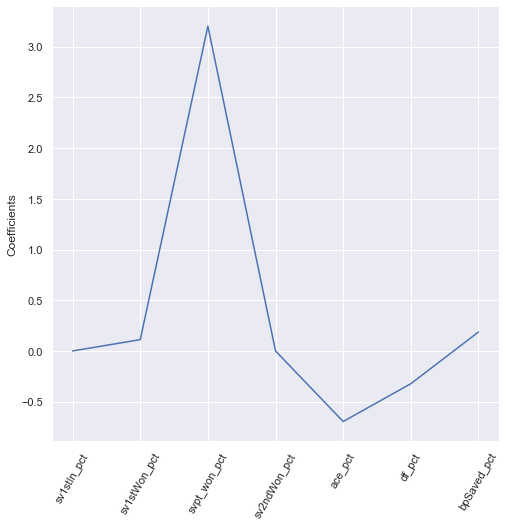

In [2104]:
plot_lasso_features(names, X, y, 0.0001)

In [2105]:
# split data into train and testing set
model_columns=['svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

[0.7336183022559027, 0.7916070889151265, 0.8165979944883006, 0.8342848888316426, 0.8431597511655127, 0.8492777170296911, 0.853603866418131, 0.8576360484317347, 0.8615441465636622, 0.8638245231522855, 0.8665393539730564, 0.8685949866093645, 0.8696176971759331, 0.8708707124964391, 0.8720640879445665, 0.8731826745063808, 0.873782002730658, 0.8744686632629055, 0.8757460474072205, 0.8761000493067648, 0.8760856185235595, 0.8765006366278474, 0.8770812891559958, 0.8781414132432808, 0.8786173649167808, 0.878858300713036, 0.8792931208034066, 0.8796407617358941, 0.8799472711533582, 0.8801804688538744]


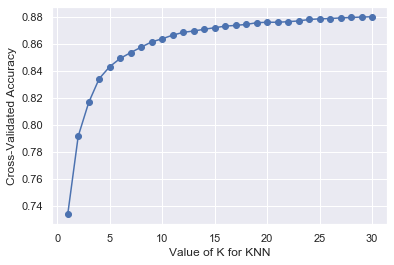

In [2106]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8603494004145064
{'n_neighbors': 30}
0.8801811354260738


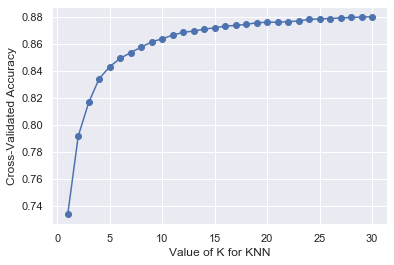

In [2107]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1998
           1       0.80      0.79      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1591  407]
 [ 422 1607]]
mean squared error:
0.20586044201638937
r2 scores:
0.17650943205403524
ROC AUC Score: 
0.8811056004254623



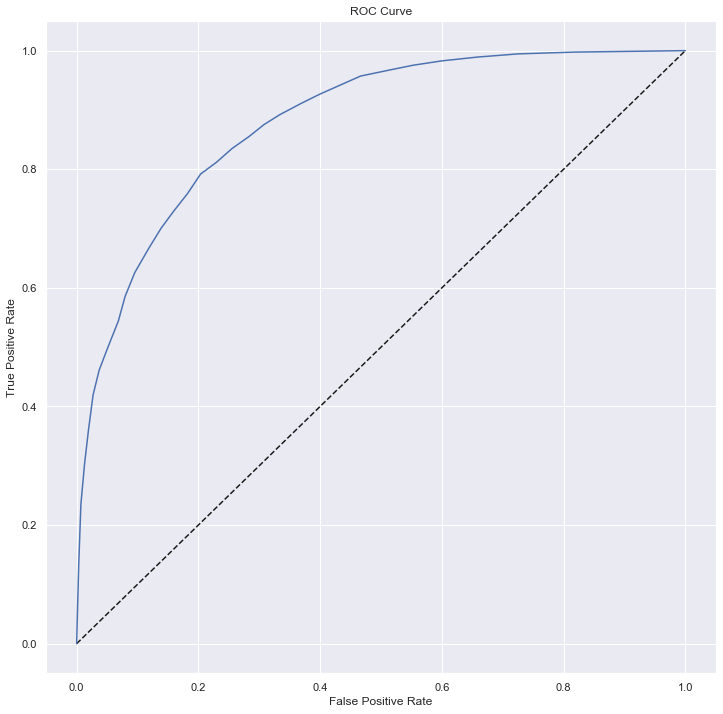

In [2108]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [2109]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.84593596 0.87491379 0.90050493 0.90097291 0.88837438 0.88504926
 0.86488916 0.85591133 0.84420873 0.89345241]
Average CV Score:
0.8754212863076539




array([0.84593596, 0.87491379, 0.90050493, 0.90097291, 0.88837438,
       0.88504926, 0.86488916, 0.85591133, 0.84420873, 0.89345241])

### Exam learninig performance¶ 

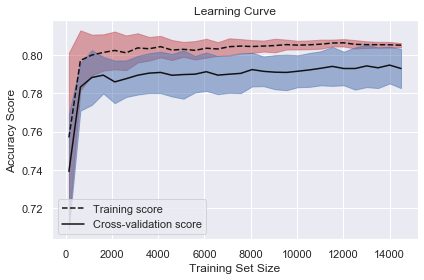

In [2110]:
#plot_learning_curve(KNeighborsClassifier(), X_train, y_train)
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

## Machine learning for Data Set 3 of selected predicotr variables (Xs) and response (won_flag) 

Further reduce features to most significant features, svpt_won_pct and bpSaved_pct

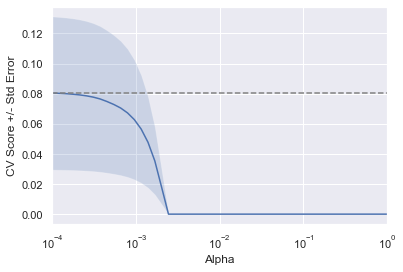

([0.0804108728452528,
  0.08022710214638303,
  0.07998050791138611,
  0.07964677162047004,
  0.07919137676955072,
  0.07856514109426253,
  0.07769774840675103,
  0.07648840713148894,
  0.07479210691084226,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538

In [2111]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

plot_lasso_alpha(X,y)

### Choose the best n_neighbors

[0.7195789763528848, 0.7763204882951718, 0.8064435673114085, 0.8252667281735159, 0.836878091381051, 0.8436385486678551, 0.8485278554354745, 0.8522067324704432, 0.855734532967127, 0.8574004756489584, 0.8593485253557693, 0.8612224756040792, 0.8625957000620094, 0.8646166133587384, 0.8661334539588841, 0.8673839373795547, 0.8681438653288429, 0.86897857372834, 0.8699562817326502, 0.8707062986420601, 0.870932399167882, 0.8720965355114212, 0.8725109229920174, 0.8727205133299044, 0.8735002924090487, 0.8737322292019971, 0.8740358160031609, 0.8741463397208982, 0.8743992156030327, 0.8748716158030119]


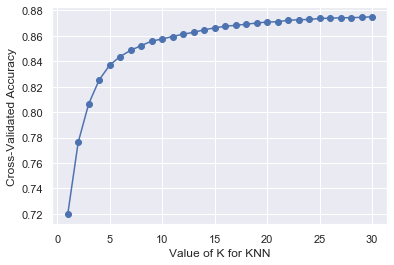

In [2112]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.8538022656507491
{'n_neighbors': 30}
0.8748722005197249


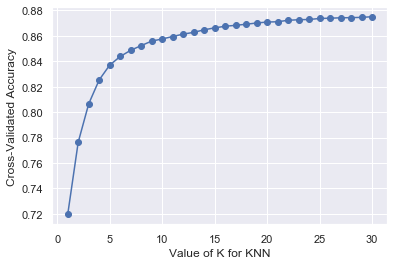

In [2113]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

In [2114]:
knn_cross_val_scores(X_test, y_test, k, n_CV)

CV Scores:
[0.84913793 0.87328818 0.89321429 0.89695813 0.87586207 0.89033251
 0.85668719 0.8692734  0.83461643 0.89524354]
Average CV Score:
0.8734613670949489




array([0.84913793, 0.87328818, 0.89321429, 0.89695813, 0.87586207,
       0.89033251, 0.85668719, 0.8692734 , 0.83461643, 0.89524354])

classification report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1998
           1       0.79      0.78      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1588  410]
 [ 444 1585]]
mean squared error:
0.21206853737273404
r2 scores:
0.15167557897966966
ROC AUC Score: 
0.8781393517716829



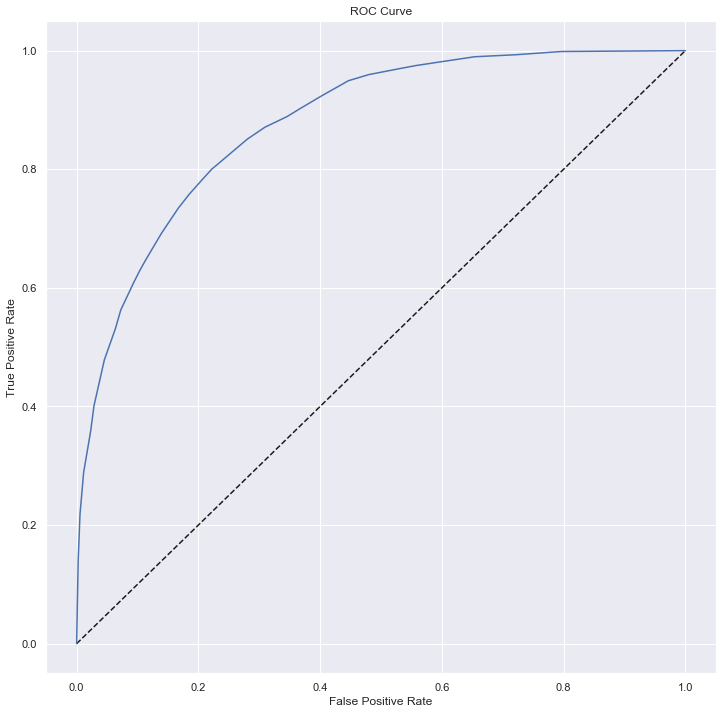

In [2115]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [2116]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.84913793 0.87328818 0.89321429 0.89695813 0.87586207 0.89033251
 0.85668719 0.8692734  0.83461643 0.89524354]
Average CV Score:
0.8734613670949489




array([0.84913793, 0.87328818, 0.89321429, 0.89695813, 0.87586207,
       0.89033251, 0.85668719, 0.8692734 , 0.83461643, 0.89524354])

### Exam learninig performance¶ 

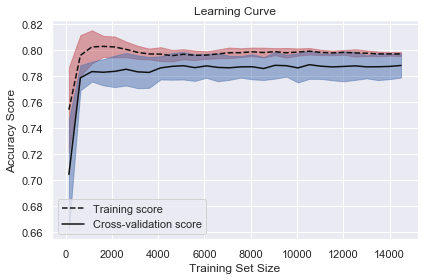

In [2117]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

Both training and testing curve keep flat after size>2000.  The varaince is big for testing curve.

### Model of data set 1 performs better than data set 2 and 3 

# Can we predict player hand based on the historic match data?

Change response y to player_hand_flag and run through the KNN models

#### Data Set 1 

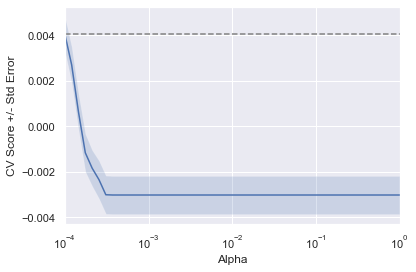

In [2118]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']

names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values
plot_lasso_alpha(X,y)
plt.show()

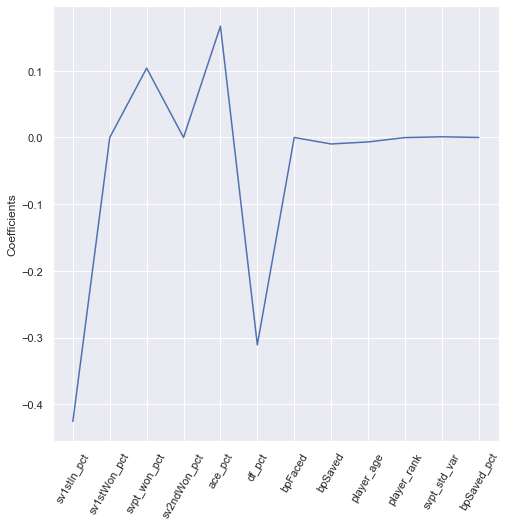

In [2119]:
plot_lasso_features(names, X, y, 0.0005)

In [2120]:
# split data into train and testing set
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
#model_columns=['sv1stIn_pct','svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

[0.5572516766554524, 0.5701618755784835, 0.5793989390399485, 0.5846147700433654, 0.5882475669812453, 0.5911828874497163, 0.5938178475389385, 0.5971233966810805, 0.5985957213189467, 0.5980595092641728, 0.5984918098859031, 0.6011789931763609, 0.6019691826749803, 0.6018982589316314, 0.6041931340169406, 0.6045067225742088, 0.6052441803460051, 0.606046080672375, 0.6059395371704894, 0.6061344395148196, 0.6058634612808576, 0.6053965819300208, 0.6068444801853337, 0.6074175711555432, 0.6080649737530518, 0.6088699164144955, 0.608480426622311, 0.6085542807311864, 0.6081129584461944, 0.6086260180493439]


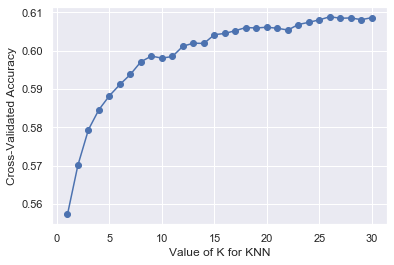

In [2121]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.5990076597344397
{'n_neighbors': 26}
0.6088671714694668


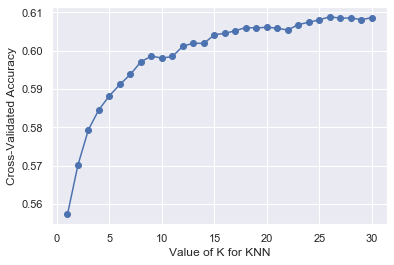

In [2122]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

In [2123]:
# exam performance using cross_val_scores
knn_cross_val_scores(X_test, y_test, k, n_CV)

CV Scores:
[0.61803922 0.61698529 0.60617647 0.596367   0.60301508 0.60502017
 0.54914969 0.65551897 0.6115058  0.57199792]
Average CV Score:
0.6033775614647177




array([0.61803922, 0.61698529, 0.60617647, 0.596367  , 0.60301508,
       0.60502017, 0.54914969, 0.65551897, 0.6115058 , 0.57199792])

classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.67      0.61      1994
         1.0       0.60      0.49      0.54      2033

    accuracy                           0.58      4027
   macro avg       0.58      0.58      0.58      4027
weighted avg       0.58      0.58      0.58      4027

confusion matrix:
[[1335  659]
 [1031 1002]]
mean squared error:
0.41966724608889994
r2 scores:
-0.6788264449028341
ROC AUC Score: 
0.6158655504141545



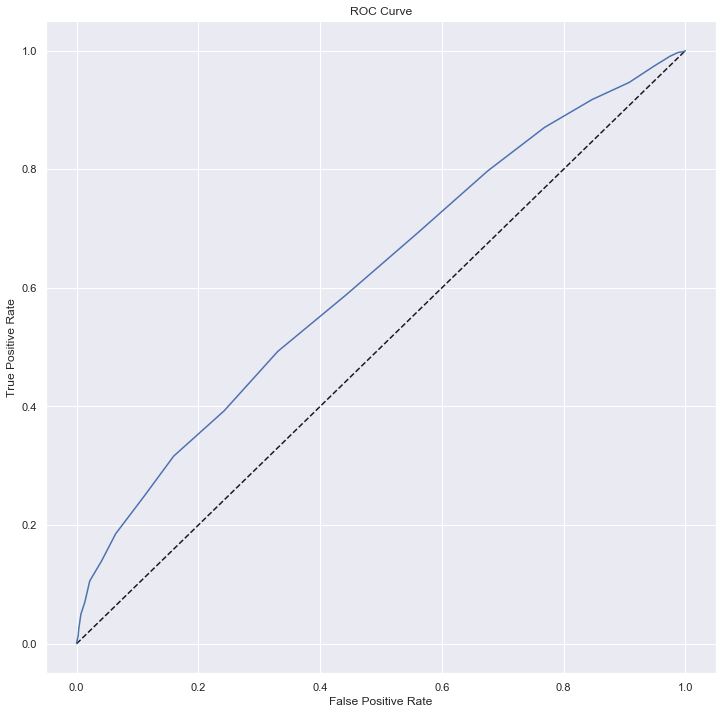

In [2124]:
# exam testing score
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [2125]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.61803922 0.61698529 0.60617647 0.596367   0.60301508 0.60502017
 0.54914969 0.65551897 0.6115058  0.57199792]
Average CV Score:
0.6033775614647177




array([0.61803922, 0.61698529, 0.60617647, 0.596367  , 0.60301508,
       0.60502017, 0.54914969, 0.65551897, 0.6115058 , 0.57199792])

### Exam learninig performance 

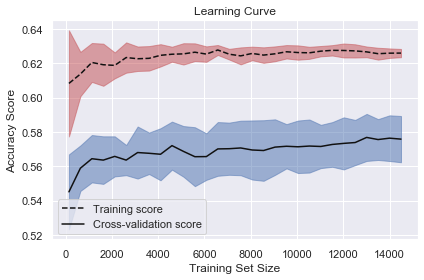

In [2126]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

•	The score of both training and testing is lower than 70%. Both training and testing curve keep flat after size>2000

•	The testing curve shows higher variability than training.  

•	The gap between training score and Cross-validation score are not decreasing even the data size increases.


#### Data Set 2 

In [2127]:
# Data set 2
model_columns_set2=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']

names_set1= df[model_columns_set2].columns
X2 = df[model_columns_set2].values
y2 = df['player_hand_flag'].values


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = p_test_size , random_state=p_random_state)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.6204629661240567
{'n_neighbors': 7}
0.6286531349525687


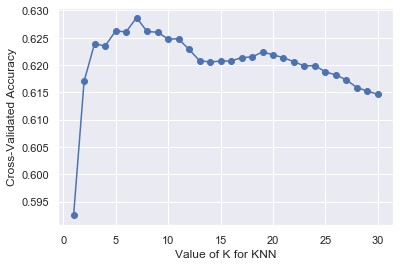

In [2128]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X2_train, y2_train, n_CV)

k= 7
CV Scores:
[0.59965686 0.55655637 0.58599265 0.64800493 0.59276679 0.55096913
 0.58912791 0.59643043 0.62989826 0.62123425]
Average CV Score:
0.5970637572825005


classification report:
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.62      1994
         1.0       0.62      0.55      0.58      2033

    accuracy                           0.60      4027
   macro avg       0.60      0.60      0.60      4027
weighted avg       0.60      0.60      0.60      4027

confusion matrix:
[[1301  693]
 [ 924 1109]]
mean squared error:
0.4015396076483735
r2 scores:
-0.6063090895904633
ROC AUC Score: 
0.6351447357320362



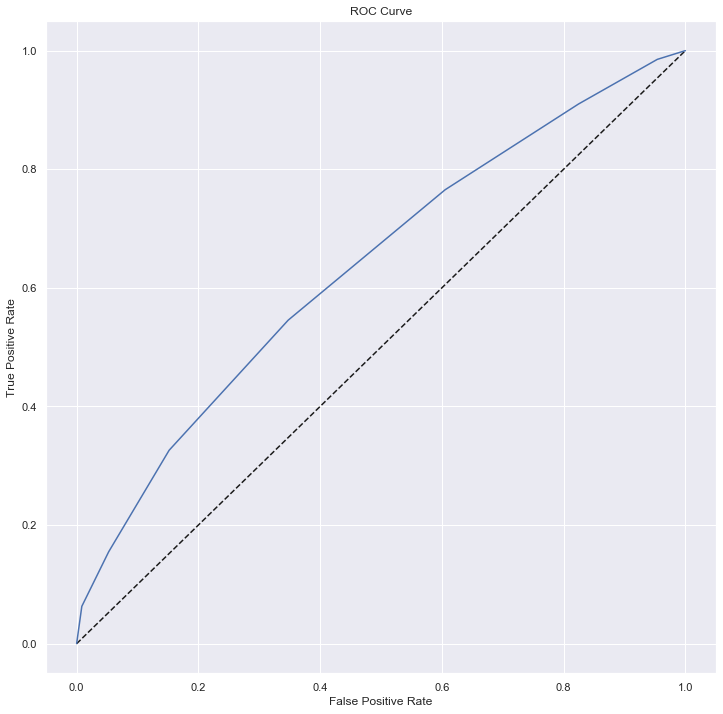

In [2129]:
# exam testing score
print('k=', k)
knn_cross_val_scores(X2_test, y2_test, k, n_CV)
knn2 = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn2, X2_train, X2_test, y2_train, y2_test)

# Logictics Regression

In [2130]:
def choose_LR_params(X_train, X_test, y_train, y_test):

    # load libraries
    from sklearn import decomposition
    from sklearn.pipeline import Pipeline
    #from sklearn.model_selection import GridSearchCV, cross_val_score
    #from sklearn.preprocessing import StandardScaler

    # Create an scaler object
    sc = StandardScaler()

    # Create a pca object
    pca = decomposition.PCA()

    # Create a logistic regression object with an L2 penalty
    logistic = LogisticRegression()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a logistic regression on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('logistic', logistic)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1]+1,1))
    # Create a list of values of the regularization parameter
    C = np.logspace(-4, 4, 50)
    # Create a list of options for the regularization penalty
    penalty = ['l1', 'l2']
    # Create a list of solver
    ##solver=['lbfgs','liblinear']
    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      logistic__C=C,
                      logistic__penalty=penalty
                      #, logistic__solver=solver
                      )

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X_train, y_train)
    # View The Best Parameters
    print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
    print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
    print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf.best_estimator_.get_params()['logistic'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X_test, y_test, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())
    print()
    ##run_train_testing_split(logisticreg, X_train, X_test, y_train, y_test)

### Predict won_flag 

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


classification report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2014
           1       0.79      0.80      0.80      2013

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

confusion matrix:
[[1580  434]
 [ 394 1619]]
mean squared error:
0.2056121182021356
r2 scores:
0.17755147647540215
ROC AUC Score: 
0.8851019761816318



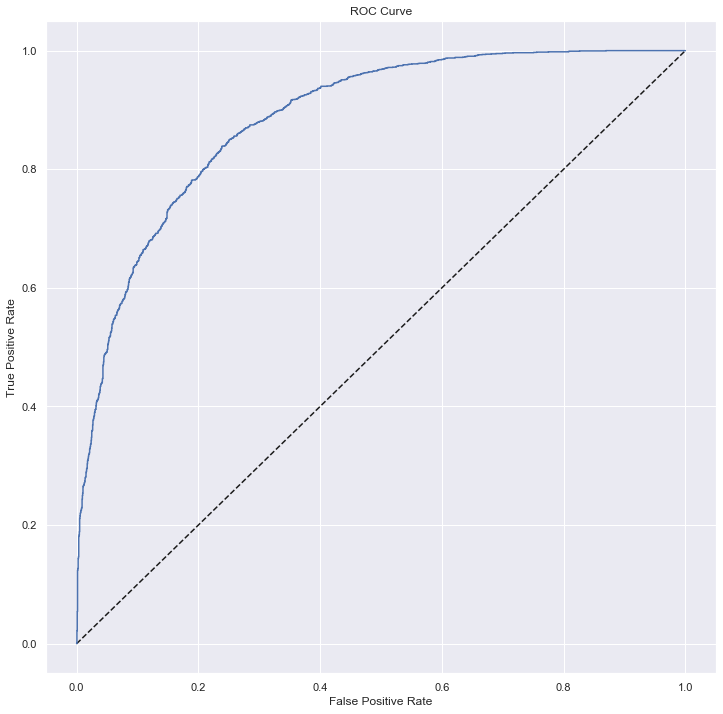

In [2131]:
# Logictics Regression
model_columns=['sv1stWon_pct','sv2ndWon_pct', 'svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
X=df[model_columns]
y=df['won_flag']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y) 
logisticreg = LogisticRegression()

run_train_testing_split(logisticreg, X_train, X_test, y_train, y_test)

In [2132]:
get_cross_val_scores(logisticreg, X_test, y_test, n_CV)

CV Scores:
[0.89991177 0.86685129 0.88765807 0.88672972 0.87445855 0.87289919
 0.9089874  0.8650776  0.89757679 0.86205787]
Average CV Score:
0.8822208252500037




array([0.89991177, 0.86685129, 0.88765807, 0.88672972, 0.87445855,
       0.87289919, 0.9089874 , 0.8650776 , 0.89757679, 0.86205787])

### Exam learninig performance¶ 

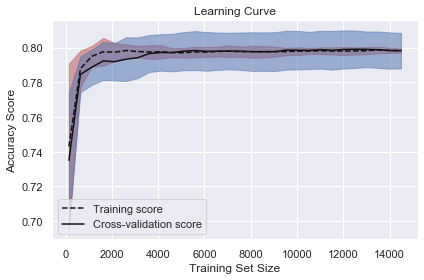

In [2133]:
#plot_learning_curve(LogisticRegression(), X_train, y_train)
plot_learning_curve(logisticreg, X_train, y_train)

### Predict player hand 

In [2134]:
# Data set 1
model_columns_set1=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']

names_set1= df[model_columns_set1].columns
X1 = df[model_columns_set1].values
y1 = df['player_hand_flag'].values


X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = p_test_size , random_state=p_random_state)
#run_train_testing_split(logisticreg, X1_train, X1_test, y1_train, y1_test)
#get_cross_val_scores(logisticreg, X1_test, y1_test, n_CV)
choose_LR_params(X1_train, X1_test, y1_train, y1_test)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best Penalty: l2
Best C: 0.0062505519252739694
Best Number Of Components: 4

LogisticRegression(C=0.0062505519252739694, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[0.53670635 0.54915591 0.54373757 0.51988072]

0.5373701370260805

0.011020085589147518



classification report:
              precision    recall  f1-score   support

         0.0       0.53      0.54      0.53      1994
         1.0       0.54      0.53      0.53      2033

    accuracy                           0.53      4027
   macro avg       0.53      0.53      0.53      4027
weighted avg       0.53      0.53      0.53      4027

confusion matrix:
[[1071  923]
 [ 958 1075]]
mean squared error:
0.4670970946113732
r2 scores:
-0.8685636348297225
ROC AUC Score: 
0.5527623204093343



C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


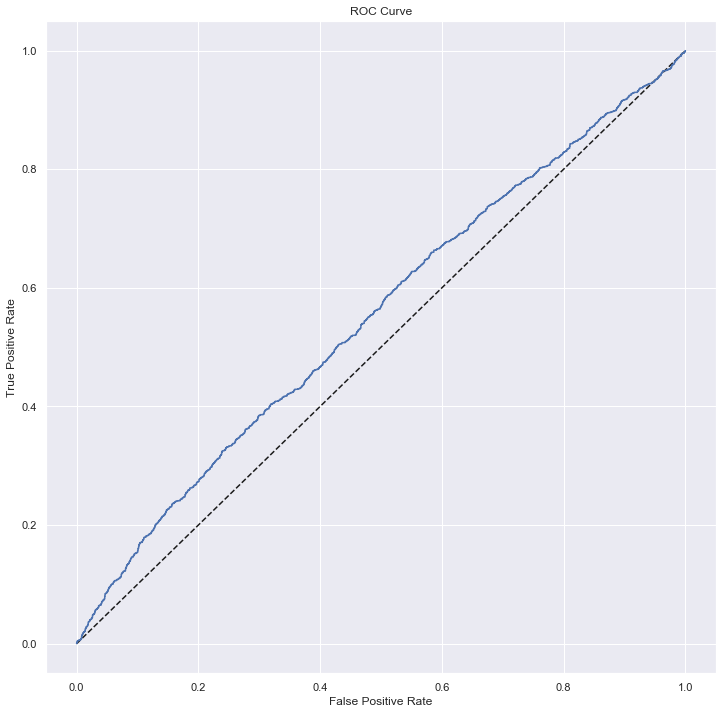

In [2135]:
logisticreg_t = LogisticRegression(C=0.00625,  penalty='l2')

run_train_testing_split(logisticreg_t, X1_train, X1_test, y1_train, y1_test)

In [2136]:
# Data set 2
model_columns_set2=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']

names_set1= df[model_columns_set2].columns
X2 = df[model_columns_set2].values
y2 = df['player_hand_flag'].values


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = p_test_size , random_state=p_random_state)
#run_train_testing_split(logisticreg, X2_train, X2_test, y2_train, y2_test)
#get_cross_val_scores(logisticreg, X2_test, y2_test, n_CV)

In [2137]:
choose_LR_params(X2_train, X2_test, y2_train, y2_test)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best Penalty: l1
Best C: 0.02811768697974228
Best Number Of Components: 5

LogisticRegression(C=0.02811768697974228, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[0.52480159 0.53227408 0.56063618 0.51689861]

0.5336526149960157

0.016500384250879407



C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57      1994
         1.0       0.58      0.55      0.56      2033

    accuracy                           0.57      4027
   macro avg       0.57      0.57      0.57      4027
weighted avg       0.57      0.57      0.57      4027

confusion matrix:
[[1169  825]
 [ 911 1122]]
mean squared error:
0.43109014154457415
r2 scores:
-0.7245223126339171
ROC AUC Score: 
0.584639062292633



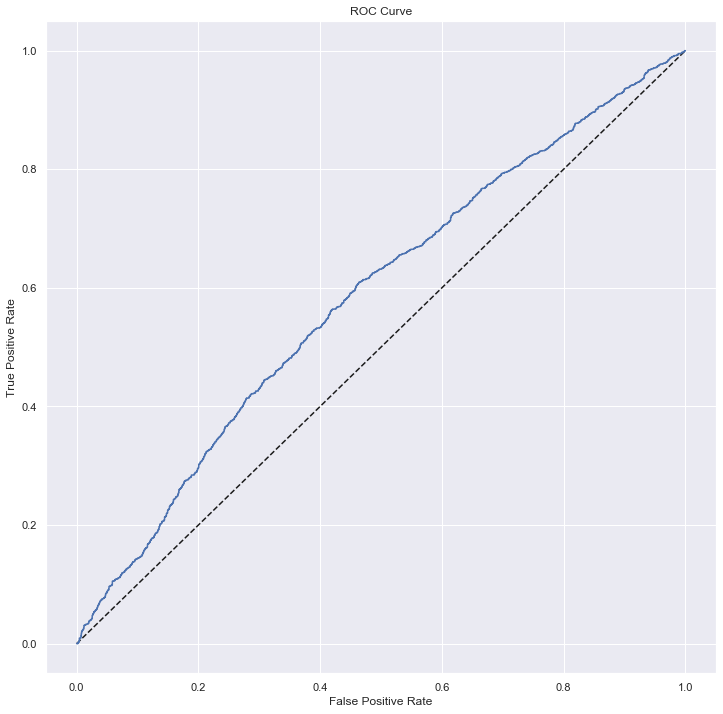

In [2138]:
logisticreg_t2 = LogisticRegression(C=0.028,  penalty='l2')

run_train_testing_split(logisticreg_t2, X2_train, X2_test, y2_train, y2_test)

# Random Forest

## Predict won_flag 

In [2139]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['won_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)


In [2140]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2141]:
y_pred = rf.predict(X_test)

In [2142]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7814640536611331

### Exam feature importane

In [2143]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.0527394513282467)
('sv1stWon_pct', 0.11007642758373118)
('svpt_won_pct', 0.23997242783059763)
('sv2ndWon_pct', 0.06139384937232547)
('ace_pct', 0.055241350752666375)
('df_pct', 0.039609249968851803)
('bpFaced', 0.08790181349216751)
('bpSaved', 0.033794045501578523)
('player_age', 0.06976416148736311)
('player_rank', 0.08260117569641051)
('svpt_std_var', 0.06977933474980787)
('bpSaved_pct', 0.09712671223625344)


## Choose Model Parameters
### N_estimators

n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

In [2144]:
def choose_N_estimators(X_train, X_test, y_train, y_test):
    # n_estimators represents the number of trees in the forest
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    
    for estimator in n_estimators:
        rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

### max_depth 
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

In [2145]:
def choose_max_depth(X_train, X_test, y_train, y_test):
    # max_depth
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.show()

### min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

In [2146]:
def choose_min_samples_split (X_train, X_test, y_train, y_test):
    # min_samples_split
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

    train_results = []
    test_results = []

    for min_samples_split in min_samples_splits:
        rf = RandomForestClassifier(min_samples_split=min_samples_split)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min samples split')
    plt.show()

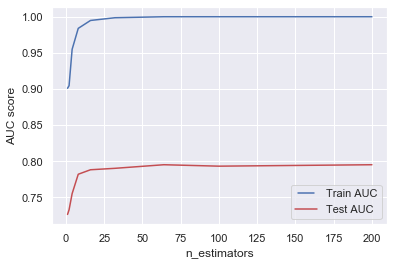

In [2147]:
choose_N_estimators(X_train, X_test, y_train, y_test)

In [2148]:
print('From the above plot, we can stop at 30 trees')

From the above plot, we can stop at 30 trees


C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

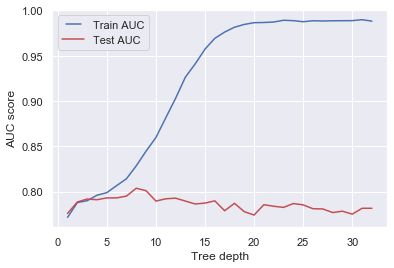

In [2149]:
choose_max_depth(X_train, X_test, y_train, y_test)

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

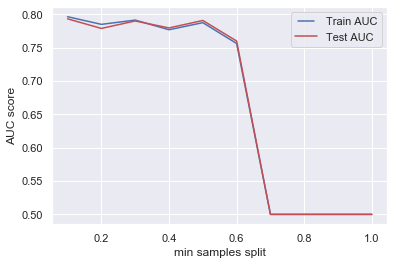

In [2150]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

Use default value 2.

classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2014
           1       0.80      0.79      0.80      2013

    accuracy                           0.80      4027
   macro avg       0.80      0.80      0.80      4027
weighted avg       0.80      0.80      0.80      4027

confusion matrix:
[[1610  404]
 [ 416 1597]]
mean squared error:
0.2036255276881053
r2 scores:
0.1854978390215335
ROC AUC Score: 
0.8876550189409356



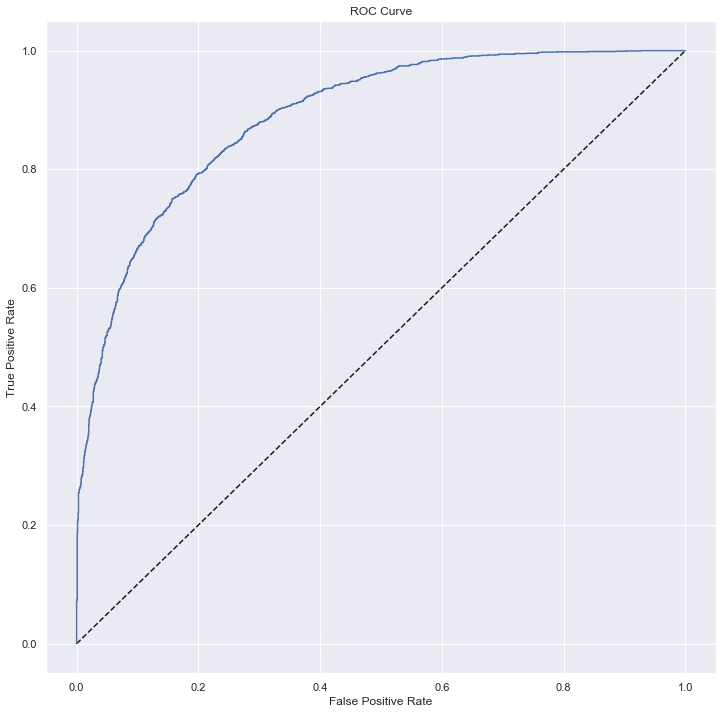

In [2151]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=30,  random_state=50, max_features='auto', n_jobs=-1, max_depth=5)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [2152]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.90420057 0.86868934 0.88998628 0.89106448 0.87205762 0.87594366
 0.91304671 0.8690874  0.9049281  0.87339422]
Average CV Score:
0.8862398379634033




array([0.90420057, 0.86868934, 0.88998628, 0.89106448, 0.87205762,
       0.87594366, 0.91304671, 0.8690874 , 0.9049281 , 0.87339422])

### Exam learninig performance¶ 

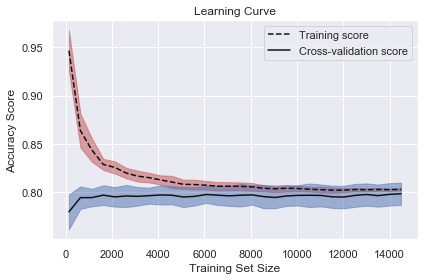

In [2153]:
plot_learning_curve(clf, X_train, y_train)

•	When training set size less than 4000, the plot shows high bias. 

•	When the training size increases, the variance gets smaller. More training data may not help. 

•	Training score and Cross-validation score are converging when the training set size increases, and the accuracy score is at 0.80. 

•	The testing curve shows higher variability than training. The variability of both training and testing are not narrow.

## Predict player hand

### Data set 1 of selected predictor variables 

In [2154]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct',
               'bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

In [2155]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2156]:
y_pred = rf.predict(X_test)

In [2157]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5837834857931883

In [2158]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.08632160482375426)
('sv1stWon_pct', 0.07530170982550247)
('svpt_won_pct', 0.07492767480007279)
('sv2ndWon_pct', 0.07083289069995548)
('ace_pct', 0.0811214273237346)
('df_pct', 0.062388589596813225)
('bpFaced', 0.05344915271375736)
('bpSaved', 0.0439082750647763)
('player_age', 0.14136430447322004)
('player_rank', 0.16086009826395736)
('svpt_std_var', 0.0892698083826842)
('bpSaved_pct', 0.06025446403177199)


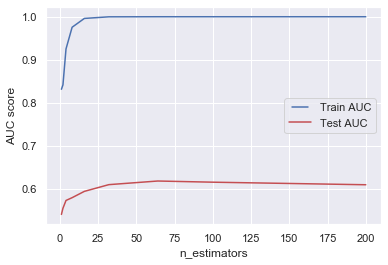

In [2159]:
choose_N_estimators(X_train, X_test, y_train, y_test)

From the plot, we can stop at 70 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

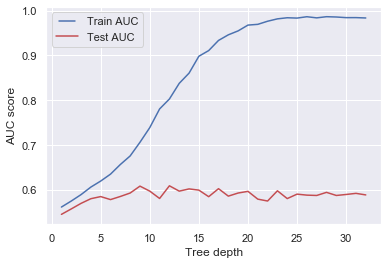

In [2160]:
choose_max_depth(X_train, X_test, y_train, y_test)

We see that the model overfits for large depth values. Choose 6

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

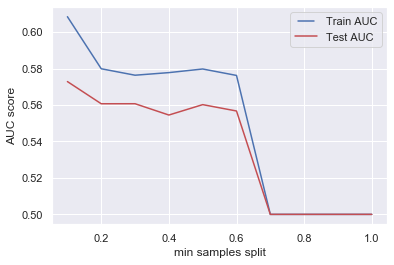

In [2161]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

Increase this value can cause underfitting.  Use default value 2.

classification report:
              precision    recall  f1-score   support

         0.0       0.57      0.74      0.64      2014
         1.0       0.63      0.44      0.52      2013

    accuracy                           0.59      4027
   macro avg       0.60      0.59      0.58      4027
weighted avg       0.60      0.59      0.58      4027

confusion matrix:
[[1486  528]
 [1119  894]]
mean squared error:
0.4089893220759871
r2 scores:
-0.635957389184798
ROC AUC Score: 
0.6401381339071606



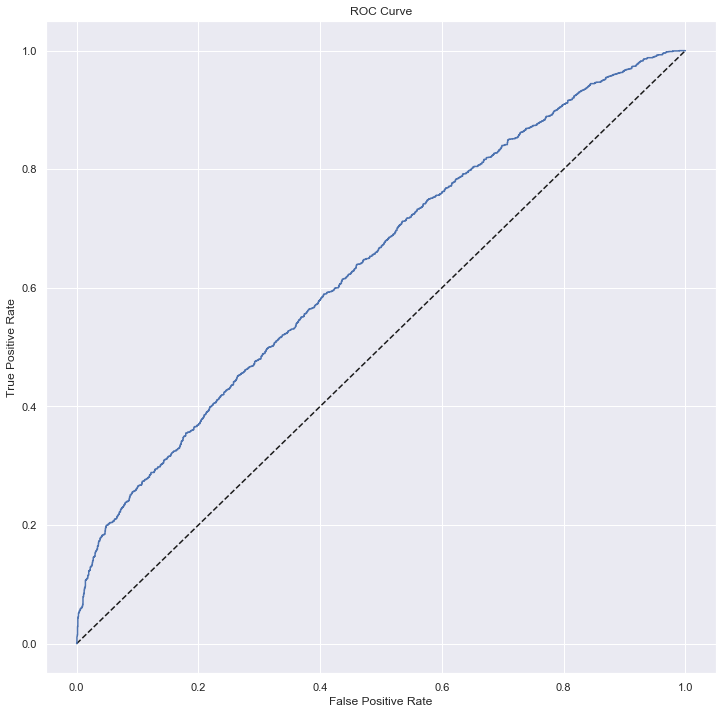

In [2162]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=15,  random_state=50, max_features='auto', n_jobs=-1, max_depth=6)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [2163]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.6255024  0.58800608 0.61603029 0.65408108 0.60186629 0.64899384
 0.62020742 0.56451573 0.58217618 0.65253335]
Average CV Score:
0.6153912664992813




array([0.6255024 , 0.58800608, 0.61603029, 0.65408108, 0.60186629,
       0.64899384, 0.62020742, 0.56451573, 0.58217618, 0.65253335])

### Exam learninig performance¶ 

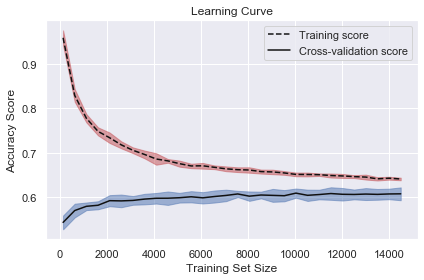

In [2164]:
plot_learning_curve(clf, X_train, y_train)


•	When the training size is increasing, the variance is getting smaller. Get more training data may help to decease. 

•	Training score and Cross-validation score are converging when the training set size increases, but the AUC score is low at 0.70. 

•	The testing curve shows higher variability than training. The variability of both training and testing are narrow.


### Data set 2 of selected predictor variables

Will apply more data to predict play hand

In [2165]:
df.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'player_hand_flag',
       'surface_id', 'tourney_level_id', 'player_rank_group', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct'],
      dtype='object')

In [2166]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

In [2167]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [2168]:
y_pred = rf.predict(X_test)

In [2169]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6796357440292518

In [2170]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn', 0.039749470988107494)
('sv1stWon', 0.037532537266525466)
('svpt', 0.040362611705480875)
('sv2ndWon', 0.03451751023495668)
('ace', 0.03486317043693845)
('df', 0.02548512684362813)
('SvGms', 0.02515675818769956)
('sv1stIn_pct', 0.04651068929234982)
('sv1stWon_pct', 0.039095578197957365)
('svpt_won_pct', 0.03943707500197849)
('sv2ndWon_pct', 0.036833485955372586)
('ace_pct', 0.039329067830918295)
('df_pct', 0.029378030420734818)
('bpSaved_pct', 0.03353116620292101)
('bpFaced', 0.02972065856573619)
('bpSaved', 0.025749191800775794)
('player_age', 0.09131730449585697)
('player_rank', 0.09353813450870921)
('player_rank_points', 0.09636379825516585)
('player_ht', 0.12157142707278158)
('svpt_std_var', 0.03995720673540554)


### Find the best params

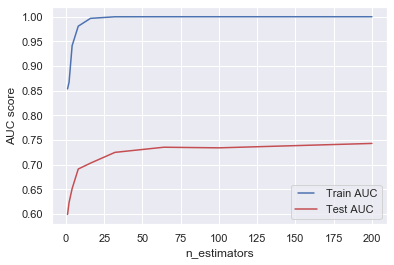

In [2171]:
choose_N_estimators(X_train, X_test, y_train, y_test)

We can stop at 100 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

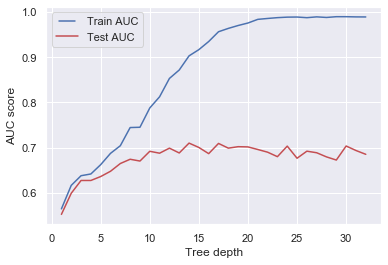

In [2172]:
choose_max_depth(X_train, X_test, y_train, y_test)

We will choose 8 a the MAX depth

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

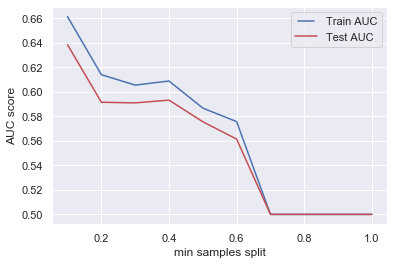

In [2173]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

classification report:
              precision    recall  f1-score   support

         0.0       0.67      0.77      0.71      2014
         1.0       0.72      0.61      0.66      2013

    accuracy                           0.69      4027
   macro avg       0.69      0.69      0.69      4027
weighted avg       0.69      0.69      0.69      4027

confusion matrix:
[[1542  472]
 [ 776 1237]]
mean squared error:
0.3099081201887261
r2 scores:
-0.23963255719649545
ROC AUC Score: 
0.7671996471791351



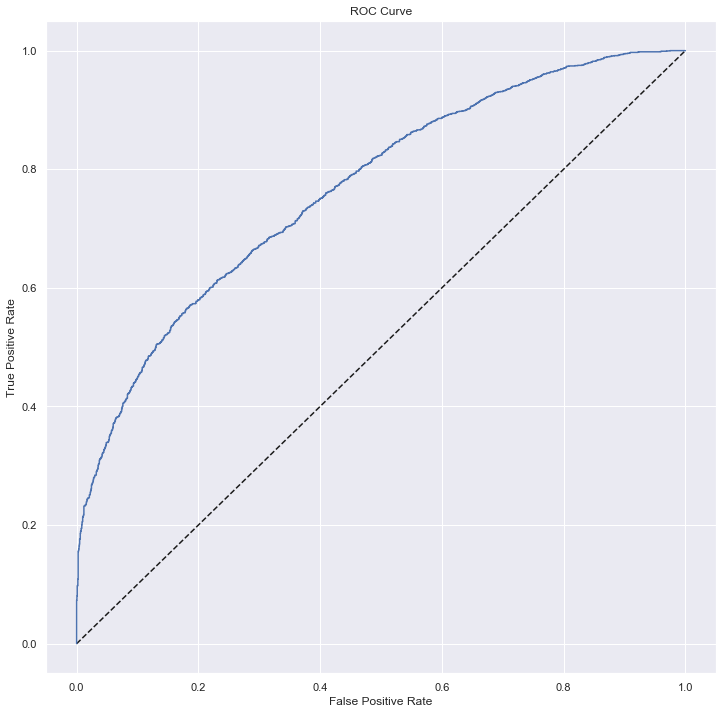

In [2174]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=100,  random_state=50, max_features='auto', n_jobs=-1, max_depth=8)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [2175]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.73686403 0.69387805 0.71713557 0.77274518 0.71711096 0.75931289
 0.73713522 0.69723522 0.71228435 0.74010544]
Average CV Score:
0.7283806923621283




array([0.73686403, 0.69387805, 0.71713557, 0.77274518, 0.71711096,
       0.75931289, 0.73713522, 0.69723522, 0.71228435, 0.74010544])

### Exam learninig performance¶ 

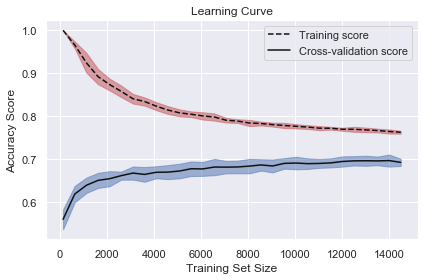

In [2176]:
plot_learning_curve(clf, X_train, y_train)

## Gradient Boosting 

#### Data Set 2 

In [2177]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

Ffirst fit a gradient boosting classifier with default parameters to get a baseline idea of the performance

In [2178]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [2179]:
y_pred = model.predict(X_test)

In [2180]:
# Use AUC(Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7062142252123857

### Functions to tune params 

#### learning_rate 

In [2181]:
def choose_GB_learning_rate (X_train, X_test, y_train, y_test):
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    
    for eta in learning_rates:
        model = GradientBoostingClassifier(learning_rate=eta)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
    line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('learning rate')
    plt.show()

#### n_estimators 

In [2182]:
def choose_GB_n_estimators (X_train, X_test, y_train, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    for estimator in n_estimators:
        model = GradientBoostingClassifier(n_estimators=estimator)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

#### ma_depth 

In [2183]:
def choose_GB_max_depth (X_train, X_test, y_train, y_test):
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        model = GradientBoostingClassifier(max_depth=max_depth)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('tree depth')
    plt.show()

#### min_sample_split 

In [2184]:
def choose_GB_min_samples_split (X_train, X_test, y_train, y_test):
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_split in min_samples_splits:
        model = GradientBoostingClassifier(min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_split')
    plt.show()

#### min_sample_leaf 

In [2185]:
def choose_GB_min_samples_leaf (X_train, X_test, y_train, y_test):
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_leaf in min_samples_leafs:
        model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_leaf')
    plt.show()

#### max_features 

In [2186]:
def choose_GB_max_features (X_train, X_test, y_train, y_test):
    max_features = list(range(1,X_train.shape[1]))
    train_results = []
    test_results = []
    
    for max_feature in max_features:
        model = GradientBoostingClassifier(max_features=max_feature)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_features')
    plt.show()

In [2187]:
# set range for tuning params 
'''
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
'''

'\nlearning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]\nn_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]\nmax_depths = np.linspace(1, 32, 32, endpoint=True)\nmin_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)\nmin_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)\nmax_features = list(range(1,X_train.shape[1]))\n'

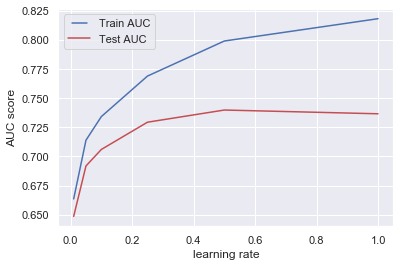

In [2188]:
choose_GB_learning_rate (X_train, X_test, y_train, y_test)

Using a high learning rate will result in overfitting.  For this data, 0.07 is optimal

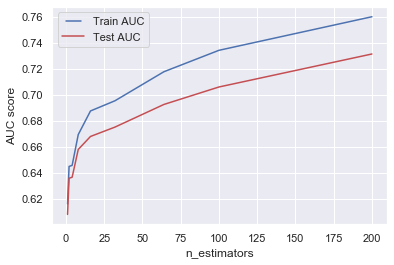

In [2189]:
choose_GB_n_estimators (X_train, X_test, y_train, y_test)

To avoid overfitting, using 20, 25, 50 trees

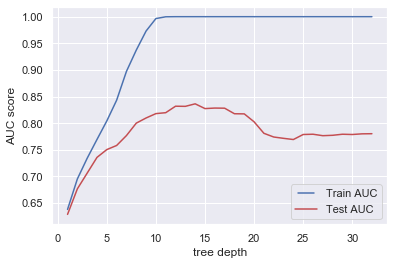

In [2190]:
choose_GB_max_depth (X_train, X_test, y_train, y_test)

The tree can grow to max depth of 8, 10 0r 15.  Overfit for large depth values.

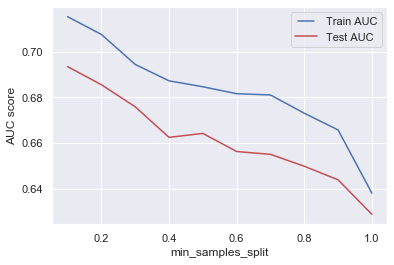

In [2191]:
choose_GB_min_samples_split (X_train, X_test, y_train, y_test)

We can split samples half.  Overall, even with all of the samples at each node, the model cannot learn enough about the dta.  This is an underfitting case. Will use the default value

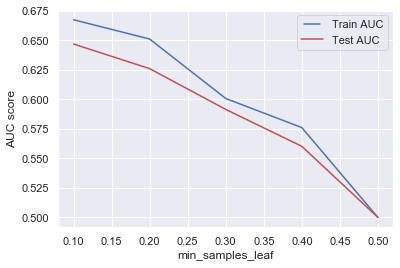

In [2192]:
choose_GB_min_samples_leaf (X_train, X_test, y_train, y_test)

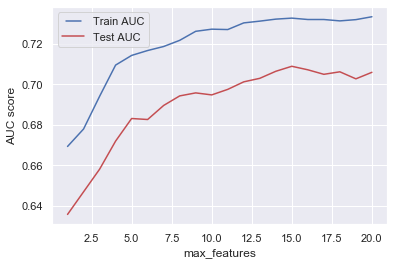

In [2193]:
choose_GB_max_features (X_train, X_test, y_train, y_test)

Try to use max_features = 17 seems to get us the optimal performance.

### First try: Use learning_rate = 0.07, n_estimators=20, max_depth=15, max_features=17

classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      2014
         1.0       0.87      0.78      0.82      2013

    accuracy                           0.83      4027
   macro avg       0.83      0.83      0.83      4027
weighted avg       0.83      0.83      0.83      4027

confusion matrix:
[[1771  243]
 [ 449 1564]]
mean squared error:
0.17184007946362057
r2 scores:
0.3126396397596356
ROC AUC Score: 
0.9086575294350376



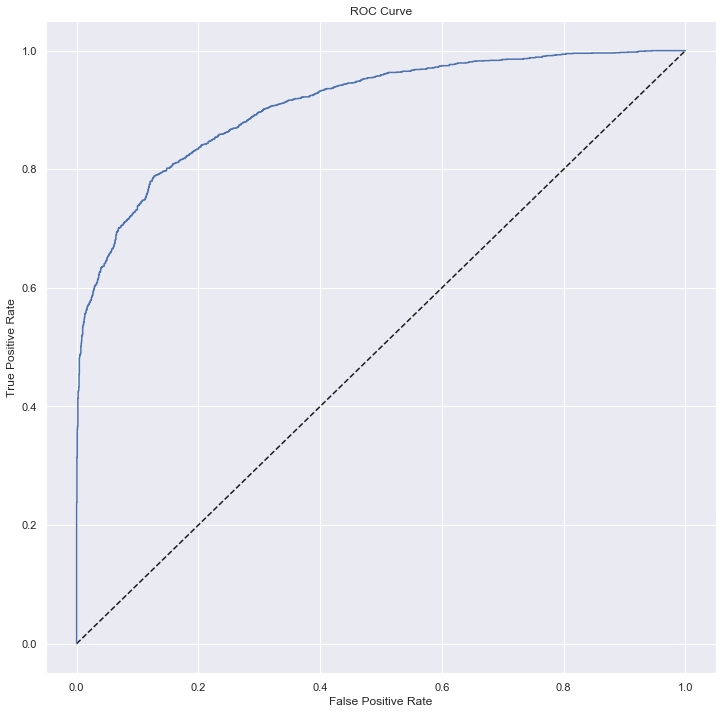

In [2194]:
m = GradientBoostingClassifier(learning_rate=0.07, n_estimators=20,max_depth=15,max_features=17)
run_train_testing_split(m, X_train, X_test, y_train, y_test)

In [2195]:
get_cross_val_scores(m, X_test, y_test, n_CV)

CV Scores:
[0.81428291 0.76695912 0.82523772 0.81390079 0.80243063 0.83734314
 0.80886612 0.76567412 0.75199871 0.81233138]
Average CV Score:
0.7999024642918957




array([0.81428291, 0.76695912, 0.82523772, 0.81390079, 0.80243063,
       0.83734314, 0.80886612, 0.76567412, 0.75199871, 0.81233138])

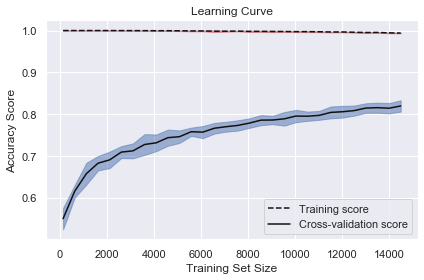

In [2196]:
plot_learning_curve(m, X_train, y_train)

•	Training score (red line) is at its maximum regardless of training examples

     o This shows severe overfitting
     
•	Cross-validation score (blue line) increases over time and reach 90%

•	The gap between cross-validation score and training score indicates high variance scenario

     o Reduce complexity of the model or gather more data


### From the above learing curve, we can see that overfitting of learning.  Remove 7 features to reduce complexity and set max_features=10

In [2197]:
model_columns_r=[#'sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names_r= df[model_columns_r].columns

Xr=df[model_columns_r]
yr=df['player_hand_flag']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=p_test_size,  random_state= p_random_state, stratify=y)

classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85      2014
         1.0       0.88      0.78      0.83      2013

    accuracy                           0.84      4027
   macro avg       0.84      0.84      0.84      4027
weighted avg       0.84      0.84      0.84      4027

confusion matrix:
[[1795  219]
 [ 435 1578]]
mean squared error:
0.16240377452197666
r2 scores:
0.3503848618537596
ROC AUC Score: 
0.9173078564307178



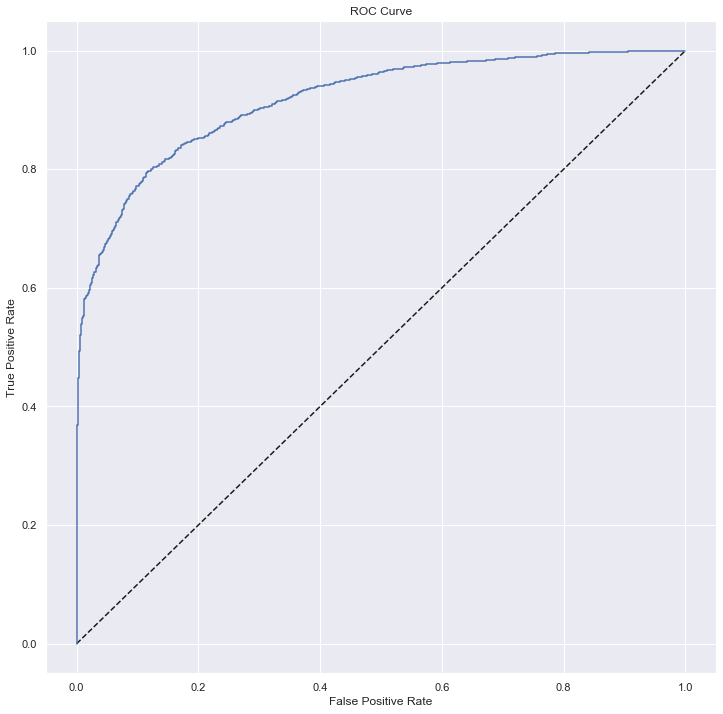

CV Scores:
[0.81680718 0.77563474 0.82330164 0.82439289 0.83406351 0.8478998
 0.79671295 0.78819831 0.79757927 0.80406426]
Average CV Score:
0.8108654547590849




array([0.81680718, 0.77563474, 0.82330164, 0.82439289, 0.83406351,
       0.8478998 , 0.79671295, 0.78819831, 0.79757927, 0.80406426])

In [2198]:
mr = GradientBoostingClassifier(learning_rate=0.07, n_estimators=20,max_depth=15,max_features=10)
run_train_testing_split(mr, Xr_train, Xr_test, yr_train, yr_test)
get_cross_val_scores(mr, Xr_test, yr_test, n_CV)

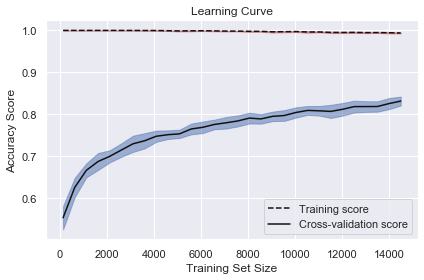

In [2199]:
plot_learning_curve(mr, Xr_train, yr_train)

• The training and test scores have not yet converged, so potentially this model would benefit from more training data.

• Cross-validation score (blue line) increases over time

• Huge gap between cross-validation score and training score indicates high variance scenario

    o Reduce complexity of the model or gather more data

#### Data Set 1 

In [2200]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 
               'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

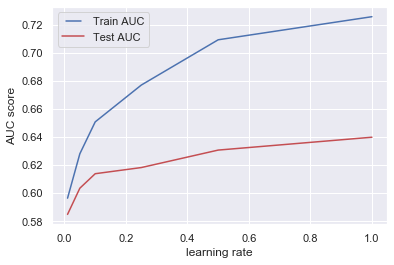

In [2201]:
choose_GB_learning_rate (X1_train, X1_test, y1_train, y1_test)

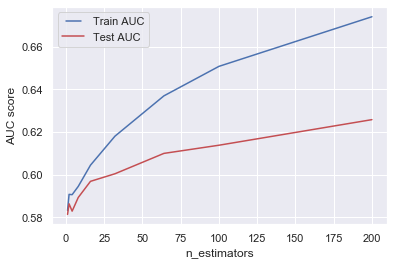

In [2202]:
choose_GB_n_estimators (X1_train, X1_test, y1_train, y1_test)

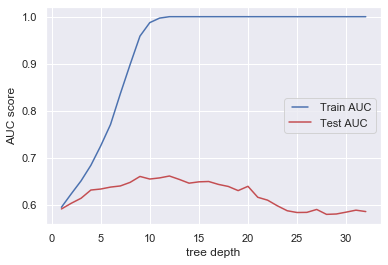

In [2203]:
choose_GB_max_depth (X1_train, X1_test, y1_train, y1_test)

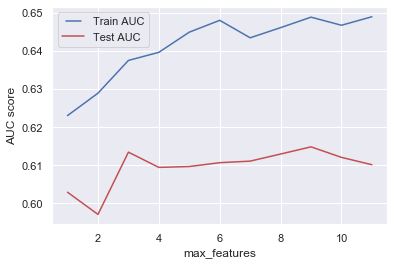

In [2204]:
choose_GB_max_features (X1_train, X1_test, y1_train, y1_test)

classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.73      0.65      1994
         1.0       0.65      0.50      0.57      2033

    accuracy                           0.61      4027
   macro avg       0.62      0.62      0.61      4027
weighted avg       0.62      0.61      0.61      4027

confusion matrix:
[[1455  539]
 [1014 1019]]
mean squared error:
0.38564688353613114
r2 scores:
-0.5427322301385216
ROC AUC Score: 
0.6867832962734737



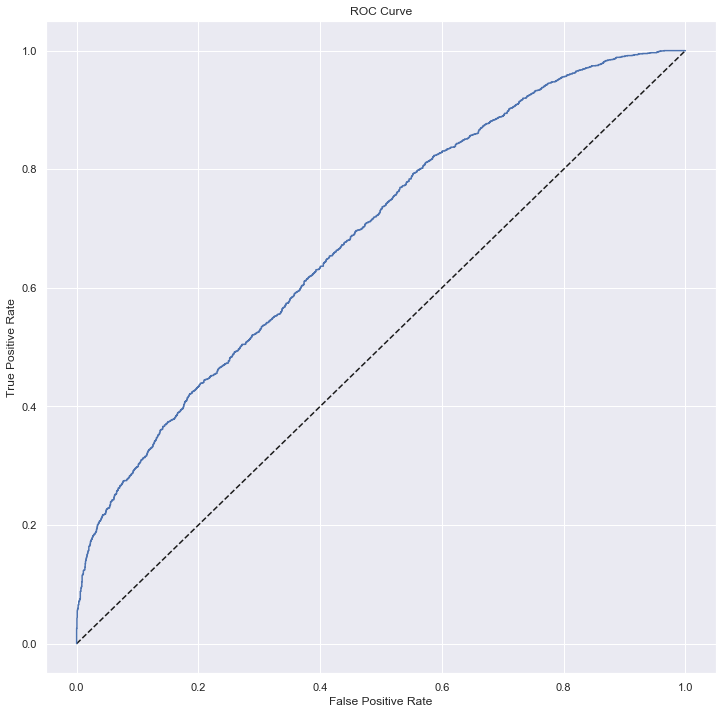

In [2205]:
#set1
gb1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=30,max_depth=5,max_features=8)
run_train_testing_split(gb1, X1_train, X1_test, y1_train, y1_test)

In [2206]:
get_cross_val_scores(gb1, X1_test, y1_test, n_CV)

CV Scores:
[0.67572304 0.71128676 0.66704657 0.66568966 0.69265044 0.67037156
 0.63394559 0.67527292 0.67712949 0.67763695]
Average CV Score:
0.6746752983683509




array([0.67572304, 0.71128676, 0.66704657, 0.66568966, 0.69265044,
       0.67037156, 0.63394559, 0.67527292, 0.67712949, 0.67763695])

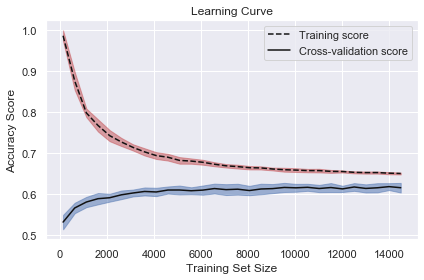

In [2207]:
plot_learning_curve(gb1, X1_train, y1_train)

### Compared the performance betwen KNeighborClassifier, LogisticRegression and RandomForestClassifier, and Gradient Boosting.  Gradient Boosting model performed best. 

### An ensemble is just a collection of predictors which come together (e.g. mean of all predictions) to give a final prediction. The reason we use ensembles is that many different predictors trying to predict same target variable will perform a better job than any single predictor alone.

### It takes more than one features to predict player hand.  As a bagging ensemble, Random Forest model performs better than classifier (KNN) and regressor (Logistic).  To further reduce variance and bias, boosting ensemble Gradient Boosting (GBM) algorithm performs better than Random Forest. 

### Gradient Boosting model has the ROC AUC score at 91%.   Gradient Boosting learning curve shows the potential to be further tuned.